## Prep Data

In [2]:
# Load libraries and instatiate DB connection

%matplotlib inline
import pandas as pd
import pymysql
import numpy as np
import time
import matplotlib.pyplot as plt
import sklearn
import sys
import pickle
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import distance
from cryptography.fernet import Fernet

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

##### Check Versions

In [3]:
print(sys.version)
print(sklearn.__version__)
print(np.version.version)

3.7.3 (default, May  2 2021, 08:49:49) 
[Clang 12.0.5 (clang-1205.0.22.9)]
0.24.2
1.20.2


##### Reading data from db

In [4]:
# Function to decrypt DB password
loc_dir_cur = os.getcwd()
path_db_pass = os.path.join(loc_dir_cur, "db/mysql_p.bin")
def get_db_pwd(key, path_db_pass):
    cipher_suite = Fernet(key)
    with open(path_db_pass, 'rb') as file_object:
        for line in file_object:
            encrypted_p = line
    uncipher_text = (cipher_suite.decrypt(encrypted_p))
    return bytes(uncipher_text).decode("utf-8")

# Connect to the database
db_host = 'localhost'
db_user = 'root'
db_pasw = get_db_pwd(b'i_oPD0alh6eBOFLyHKUzjlhux-p5hERBWvql4SEkTuo=', path_db_pass)
connection = pymysql.connect(host=db_host, user=db_user, password=db_pasw, db='movies', charset='utf8')

# Pull table from database
cur = connection.cursor()

cur.execute("select * FROM bom")
bom_sql = []
for row in cur: bom_sql.append(list(row))

cur.execute("select movie_id,genre FROM omdb_movie_genre a join omdb_genres b on a.genre_id=b.genre_id")
omdb_genre_learning_data = []
for row in cur: omdb_genre_learning_data.append(list(row))

cur.execute("select a.key_bom,a.key_omdb,b.movie_id FROM movies_final a join omdb b on a.key_omdb=b.key_omdb")
omdb_bom_combine = []
for row in cur: omdb_bom_combine.append(list(row))

cur.close()
connection.close()

In [5]:
# Store bom table information in DataFrame

bom_columns =         ['bom_title', 'bom_link', 'key_bom', 'bom_date', 'bom_year', 'bom_name', 'bom_budget',
                       'bom_domestic_gross', 'bom_lifetime_gross', 'bom_release_date', 'bom_runtime', 'bom_distributor',
                       'bom_genre', 'bom_rating', 'bom_awards', 'bom_actor', 'bom_assoc_producer', 'bom_cinematographer',
                       'bom_composer', 'bom_director', 'bom_exec_producer', 'bom_line_producer', 'bom_players', 'bom_producer',
                       'bom_writer', 'bom_close_date', 'bom_domestic_summary', 'bom_in_release', 'bom_limited_opening_weekend',
                       'bom_opening_weekend', 'bom_wide_opening_weekend', 'bom_widest_release', 'bom_domestic_revenue',
                       'bom_foreign_revenue', 'bom_worldwide_revenue', 'bom_total_lifetime_gross']

bom = pd.DataFrame(bom_sql, columns=bom_columns)
#bom.to_csv('bom.csv')
print('Total movies from Box Office Mojo:', len(bom))
bom.head(1)

Total movies from Box Office Mojo: 16826


,bom_title,bom_link,key_bom,bom_date,bom_year,bom_name,bom_budget,bom_domestic_gross,bom_lifetime_gross,bom_release_date,bom_runtime,bom_distributor,bom_genre,bom_rating,bom_awards,bom_actor,bom_assoc_producer,bom_cinematographer,bom_composer,bom_director,bom_exec_producer,bom_line_producer,bom_players,bom_producer,bom_writer,bom_close_date,bom_domestic_summary,bom_in_release,bom_limited_opening_weekend,bom_opening_weekend,bom_wide_opening_weekend,bom_widest_release,bom_domestic_revenue,bom_foreign_revenue,bom_worldwide_revenue,bom_total_lifetime_gross
0,#horror,http://www.boxofficemojo.com/movies/?id=horrorifc.htm,b0,20-Nov-15,2015\r,#Horror,N/A,,,20-Nov-15,1 hrs. 30 min.,IFC,Horror,Unknown,No Academy Awards Information\r,"""['Balthazar Getty', 'Timothy Hutton', 'Natasha Lyonne', 'Taryn Manning', 'Chloe Sevigny']""",,,,,,,,,\r,,No Domestic Summary Information,,,,,\r,,,,No Total Lifetime Gross Information\r


###### Filtering for movies with budgter and gross

In [6]:
print("no:of movies in bom where budget and bom_worldwide_revenue is not null:")
g = bom.bom_worldwide_revenue
print(bom[(bom.bom_budget!="") & (bom.bom_budget!="N/A") & (g!="")].shape)

bom_f = bom[(bom.bom_budget!="") & (bom.bom_budget!="N/A") & (g!="")]
bom_f= bom_f[["key_bom","bom_title","bom_budget","bom_worldwide_revenue"]]
print("Bom movies with budget/gross (worldwide) info: ", bom_f.shape)

no:of movies in bom where budget and bom_worldwide_revenue is not null:
(2530, 36)
Bom movies with budget/gross (worldwide) info:  (2530, 4)


###### Cleaning budget, gross column

In [7]:
bom_f.reset_index(inplace=True,drop=True)
movie_df = bom_f
# Cleaning bom budget and revenue
movie_df.loc[movie_df.bom_budget == "",'bom_budget']= movie_df.loc[movie_df.bom_budget=="",'bom_budget'].apply(lambda x: float(x.replace('', '0.0')))
movie_df.loc[movie_df.bom_worldwide_revenue == "",'bom_worldwide_revenue'] = movie_df.loc[movie_df.bom_worldwide_revenue=="",'bom_worldwide_revenue'].apply(lambda x: float(x.replace('', '0.0')))

import warnings
warnings.filterwarnings('ignore')

movie_df['bom_budget'] = movie_df['bom_budget'].str.replace('$','')
movie_df['bom_budget'] = movie_df['bom_budget'].str.replace('"','')
movie_df['bom_budget'] = movie_df['bom_budget'].str.replace(',','')

for r in range(0,movie_df.shape[0]):
    s = str(movie_df.loc[r,'bom_budget'])
    if("million" in s):
        movie_df.loc[r,'bom_budget'] = movie_df.loc[r,'bom_budget'].replace("million","")
        movie_df.loc[r,'bom_budget'] = float(movie_df.loc[r,'bom_budget'])*1000000
    else:
        movie_df.loc[r,'bom_budget'] = float(movie_df.loc[r,'bom_budget'])
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace('$','')
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace('"','')
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace(',','')
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace('n/a','')

movie_df.loc[movie_df.bom_worldwide_revenue == "",'bom_worldwide_revenue'] = movie_df.loc[movie_df.bom_worldwide_revenue=="",'bom_worldwide_revenue'].apply(lambda x: float(x.replace('', '0.0')))


for r in range(0,movie_df.shape[0]):
    #print(movie_df.loc[r,'bom_worldwide_revenue'])
    movie_df.loc[r,'bom_worldwide_revenue'] = float(movie_df.loc[r,'bom_worldwide_revenue'])

In [8]:
movie_df.head(2)

,key_bom,bom_title,bom_budget,bom_worldwide_revenue
0,b10,(500) days of summer,7500000.0,60722734.0
1,b24,10 things i hate about you,30000000.0,53478166.0


In [9]:
print(movie_df.shape)
movie_df = movie_df[(movie_df['bom_budget']!=0.0)&(movie_df['bom_worldwide_revenue']!=0.0)]
movie_df.reset_index(inplace=True,drop=True)
print(movie_df.shape)

(2530, 4)
(2527, 4)


###### Filtering budget, gross > 10,000

In [10]:
movie_df = movie_df[(movie_df['bom_budget']>10000) & (movie_df['bom_worldwide_revenue']>10000)]
movie_df.reset_index(inplace=True,drop=True)
print(movie_df.shape)

(2520, 4)


In [11]:
movie_df['revenue'] = (movie_df['bom_worldwide_revenue'] - movie_df['bom_budget']) / movie_df['bom_budget']
movie_df.head(2)

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606


In [12]:
movie_df[movie_df['revenue']<1].shape

(1100, 5)

In [13]:
#movie_df.to_csv("data/temp-data/bom_1.csv",index=None)

In [14]:
movie_df[movie_df['revenue']>10].shape

(147, 5)

In [15]:
# Filtering revenue < 10
movie_df = movie_df[movie_df['revenue']<10]
movie_df.reset_index(inplace=True,drop=True)
movie_df.shape

(2373, 5)

## Features related to release date

In [16]:
movie_df = movie_df.merge(bom[['bom_release_date',"key_bom"]],on="key_bom",how="left",)
movie_df.shape

(2373, 6)

In [17]:
movie_df.head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,17-Jul-09
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,31-Mar-99
2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,7-Mar-08
3,b38,102 dalmatians,85000000.0,183611771.0,1.160138,22-Nov-00
4,b39,10th &amp; wolf,8000000.0,143451.0,-0.982069,18-Aug-06


In [18]:
import datetime as dt

for r in range(0,movie_df.shape[0]):
    if(len(movie_df.loc[r,'bom_release_date'])>=8):   
        movie_df.loc[r,'bom_release_date'] = pd.to_datetime(movie_df.loc[r,'bom_release_date'], format='%d-%b-%y')
    else:
        movie_df.loc[r,'bom_release_date'] = ""

movie_df.head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,1999-03-31 00:00:00
2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,2008-03-07 00:00:00
3,b38,102 dalmatians,85000000.0,183611771.0,1.160138,2000-11-22 00:00:00
4,b39,10th &amp; wolf,8000000.0,143451.0,-0.982069,2006-08-18 00:00:00


In [19]:
movie_df_3 = movie_df
# Get the month as a feature
from datetime import datetime 
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_month'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%m")
    else:
        movie_df_3.loc[r,'release_month'] = ""
        
# Get the quarter
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_quarter'] = movie_df_3.loc[r,'bom_release_date'].quarter
    else:
        movie_df_3.loc[r,'release_quarter'] = ""
        
# Get the day of the year
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_day_of_the_year'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%j").lstrip("0")
    else:
        movie_df_3.loc[r,'release_day_of_the_year'] = ""

# get the week of the year
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_week_of_the_year'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%U").lstrip("0")
    else:
        movie_df_3.loc[r,'release_week_of_the_year'] = ""

# get the year
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_year'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%Y")
    else:
        movie_df_3.loc[r,'release_year'] = ""


movie_df = movie_df_3
print(movie_df.shape)
movie_df.head()

(2373, 11)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00,07,3.0,198,28,2009
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,1999-03-31 00:00:00,03,1.0,90,13,1999
2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,2008-03-07 00:00:00,03,1.0,67,9,2008
3,b38,102 dalmatians,85000000.0,183611771.0,1.160138,2000-11-22 00:00:00,11,4.0,327,47,2000
4,b39,10th &amp; wolf,8000000.0,143451.0,-0.982069,2006-08-18 00:00:00,08,3.0,230,33,2006


## Features Related to Runtime

In [20]:
movie_df = movie_df.merge(bom[['bom_runtime',"key_bom"]],on="key_bom",how="left")
movie_df.shape

(2373, 12)

In [21]:
movie_df['bom_runtime'] = [str(v).lstrip() for v in movie_df['bom_runtime']]
movie_df['bom_runtime']= [str(v).rstrip() for v in movie_df['bom_runtime']]
movie_df['bom_runtime']= [v.replace('N/A',"") for v in movie_df['bom_runtime']]

for r in range(0,movie_df.shape[0]):
    if(movie_df.loc[r,'bom_runtime']!=""):
        a = movie_df.loc[r,'bom_runtime'].replace(" ","")
        a = a.split('hrs.')
        if (len(a)>1):
            m = a[1].split('min.')[0]
        else:
            m = 0
        movie_df.loc[r,'runtime'] = float(a[0])*60+float(m)
    else:
        movie_df.loc[r,'runtime'] = ""

In [22]:
movie_df.head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00,07,3.0,198,28,2009,1 hrs. 35 min.,95.0
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,1999-03-31 00:00:00,03,1.0,90,13,1999,1 hrs. 37 min.,97.0
2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,2008-03-07 00:00:00,03,1.0,67,9,2008,1 hrs. 49 min.,109.0
3,b38,102 dalmatians,85000000.0,183611771.0,1.160138,2000-11-22 00:00:00,11,4.0,327,47,2000,1 hrs. 44 min.,104.0
4,b39,10th &amp; wolf,8000000.0,143451.0,-0.982069,2006-08-18 00:00:00,08,3.0,230,33,2006,1 hrs. 50 min.,110.0


In [23]:
movie_df.loc[movie_df.runtime == "",'runtime']= movie_df.loc[movie_df.runtime=="",'runtime'].apply(lambda x: float(x.replace('', '0.0')))
movie_df['runtime'] = movie_df['runtime'].astype(float)
movie_df.shape

(2373, 13)

In [24]:
#movie_df.to_csv("data/temp-data/bom_2.csv",index=None)

## Features Related to Awards

In [25]:
# Create a score for awards and add it to the table
award_win_factor = 5
bom_awa = bom[~bom['bom_awards'].str.contains('No Academy Awards Information')][['key_bom','bom_awards']].copy()
bom_awa['bom_awards_num'] = bom_awa['bom_awards'].str.replace('\r','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace('Nominated for ','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(' Oscars','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(' Oscar','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(', Including','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(' Win.','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace('.','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace('"','')

alpha_to_num = {'One':1, 'Two':2, 'Three':3, 'Four':4, 'Five':5, 'Six':6, 'Seven':7, 'Eight':8, 'Nine':9, 
                'Ten':10, 'Eleven':11, 'Twelve':12, 'Thirteen':13, 'Fourteen':14}
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].apply(lambda x: x.split(' '))
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].apply(lambda x: [alpha_to_num[val] for val in x ])
bom_awa['bom_awards_scr'] = bom_awa['bom_awards_num'].apply(lambda x: x[0]+x[1]*award_win_factor if len(x)>1 else x[0] )

movie_df = pd.merge(movie_df,bom_awa[['key_bom', 'bom_awards', 'bom_awards_scr']],on = "key_bom",how="left")
movie_df['bom_awards_scr'].fillna(0, inplace=True)

print('Shape of finalized table', movie_df.shape)
movie_df.head(3)

Shape of finalized table (2373, 15)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00,07,3.0,198,28,2009,1 hrs. 35 min.,95.0,NaN,0.0
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,1999-03-31 00:00:00,03,1.0,90,13,1999,1 hrs. 37 min.,97.0,NaN,0.0
2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,2008-03-07 00:00:00,03,1.0,67,9,2008,1 hrs. 49 min.,109.0,NaN,0.0


In [26]:
movie_df[movie_df['bom_awards'].isnull()].shape

(1927, 15)

In [27]:
movie_df[~movie_df['bom_awards'].isnull()].head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr
3,b38,102 dalmatians,85000000.0,183611771.0,1.160138,2000-11-22 00:00:00,11,4.0,327,47,2000,1 hrs. 44 min.,104.0,Nominated for One Oscar.\r,1.0
5,b48,12 years a slave,20000000.0,187733202.0,8.38666,2013-10-18 00:00:00,10,4.0,291,41,2013,2 hrs. 13 min.,133.0,"""Nominated for Nine Oscars, Including Three Wins.""\r",24.0
6,b50,127 hours,18000000.0,60738797.0,2.374378,2010-11-05 00:00:00,11,4.0,309,44,2010,1 hrs. 33 min.,93.0,Nominated for Six Oscars.\r,6.0
8,b55,13 hours: the secret soldiers of benghazi,50000000.0,69411370.0,0.388227,2016-01-15 00:00:00,01,1.0,15,2,2016,2 hrs. 24 min.,144.0,Nominated for One Oscar.\r,1.0
11,b80,1941,35000000.0,92455742.0,1.641593,1979-12-14 00:00:00,12,4.0,348,49,1979,1 hrs. 58 min.,118.0,Nominated for Three Oscars.\r,3.0


## Features Related to Holiday Season

In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from datetime import timedelta

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='1900-01-01', end='2017-12-31').to_pydatetime()

holidays_new = list(holidays)
print(len(holidays_new))

for h in holidays:
    holidays_new.append(h + datetime.timedelta(days=7))
    holidays_new.append(h + datetime.timedelta(days=6))
    holidays_new.append(h + datetime.timedelta(days=5))
    holidays_new.append(h + datetime.timedelta(days=4))
    holidays_new.append(h + datetime.timedelta(days=3))
    holidays_new.append(h + datetime.timedelta(days=2))
    holidays_new.append(h + datetime.timedelta(days=1))
    
    holidays_new.append(h - datetime.timedelta(days=7))
    holidays_new.append(h - datetime.timedelta(days=6))
    holidays_new.append(h - datetime.timedelta(days=5))
    holidays_new.append(h - datetime.timedelta(days=4))
    holidays_new.append(h - datetime.timedelta(days=3))
    holidays_new.append(h - datetime.timedelta(days=2))
    holidays_new.append(h - datetime.timedelta(days=1))
    
print(len(holidays_new))

1094
16410


In [29]:
movie_df = movie_df.fillna("")

for r in range(0,movie_df.shape[0]):
    if(movie_df.loc[r,'bom_release_date']!=""):
        if movie_df.loc[r,'bom_release_date'] in holidays_new:
            movie_df.loc[r,'holiday_season'] = 1
        else:
            movie_df.loc[r,'holiday_season'] = 0
    else:
        movie_df.loc[r,'holiday_season'] = ""
        
print(movie_df.shape)
movie_df.head(3)

(2373, 16)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00,07,3.0,198,28,2009,1 hrs. 35 min.,95.0,,0.0,0.0
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,1999-03-31 00:00:00,03,1.0,90,13,1999,1 hrs. 37 min.,97.0,,0.0,0.0
2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,2008-03-07 00:00:00,03,1.0,67,9,2008,1 hrs. 49 min.,109.0,,0.0,0.0


## Features Related to MPAA Rating

Categories 1 to 7 as listed below

* G
* PG/M/GP
* PG-13
* R
* NC-17/X
* Unrated/Not Rated/ Not Yet rated
* Unknown

In [30]:
bom['bom_rating'] = [v.upper() for k,v in bom['bom_rating'].iteritems()]
print("No: of unique rating from bom",bom['bom_rating'].unique().shape)
bom['bom_rating'].unique().tolist()

No: of unique rating from bom (12,)


['UNKNOWN',
 'R',
 'UNRATED',
 'PG-13',
 'PG',
 'NOT YET RATED',
 'G',
 'NC-17',
 'M',
 'GP',
 'M/PG',
 'X']

In [31]:
# Merging the movies_df to bom omdb to fetch MPAA rating
print(movie_df.shape)
movie_df = movie_df.fillna("")
movie_df = pd.merge(movie_df,bom[["key_bom","bom_rating"]],on="key_bom",how="left")
print(movie_df.shape)

(2373, 16)
(2373, 17)


In [32]:
for r in range(0,movie_df.shape[0]):
    if(movie_df.loc[r,'bom_rating']=="G"):
        movie_df.loc[r,'mpaa_rating'] = 1
    elif(movie_df.loc[r,'bom_rating']=="PG" or movie_df.loc[r,'bom_rating']=="M" or movie_df.loc[r,'bom_rating']=="GP"):
        movie_df.loc[r,'mpaa_rating'] = 2
    elif(movie_df.loc[r,'bom_rating']=="PG-13"):
        movie_df.loc[r,'mpaa_rating'] = 3
    elif(movie_df.loc[r,'bom_rating']=="R"):
        movie_df.loc[r,'mpaa_rating'] = 4
    elif(movie_df.loc[r,'bom_rating']=="NC-17" or movie_df.loc[r,'bom_rating']=="X"):
        movie_df.loc[r,'bom_rating'] = 5
    elif(movie_df.loc[r,'bom_rating']=="UNRATED" or movie_df.loc[r,'bom_rating']=="NOT RATED" or movie_df.loc[r,'bom_rating']=="NOT YET RATED"):
        movie_df.loc[r,'mpaa_rating'] = 6
    else:
        movie_df.loc[r,'mpaa_rating'] = 7

movie_df['mpaa_rating'] = movie_df['mpaa_rating'].astype(object)
print(movie_df.shape)
movie_df.head(3)

(2373, 18)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating
0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00,07,3.0,198,28,2009,1 hrs. 35 min.,95.0,,0.0,0.0,PG-13,3.0
1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,1999-03-31 00:00:00,03,1.0,90,13,1999,1 hrs. 37 min.,97.0,,0.0,0.0,PG-13,3.0
2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,2008-03-07 00:00:00,03,1.0,67,9,2008,1 hrs. 49 min.,109.0,,0.0,0.0,PG-13,3.0


## Features Related to Genre

In [33]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [34]:
# Data containing genre information
omdb_genre_learning_df = pd.DataFrame(omdb_genre_learning_data, columns=["omdb_movie_id", "omdb_genres"])
# One hot encoding
omdb_genre_learning_df['values'] = 1
omdb_genre_learning_table = omdb_genre_learning_df.pivot(index='omdb_movie_id', columns='omdb_genres', values='values')
omdb_genre_learning_table = omdb_genre_learning_table.fillna(0)

In [35]:
omdb_genre_learning_table = omdb_genre_learning_table.loc[omdb_genre_learning_table['Reality-TV'] != 1]
del omdb_genre_learning_table['Reality-TV']
omdb_genre_learning_table.head(1)

omdb_genres,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,N/A,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
omdb_movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


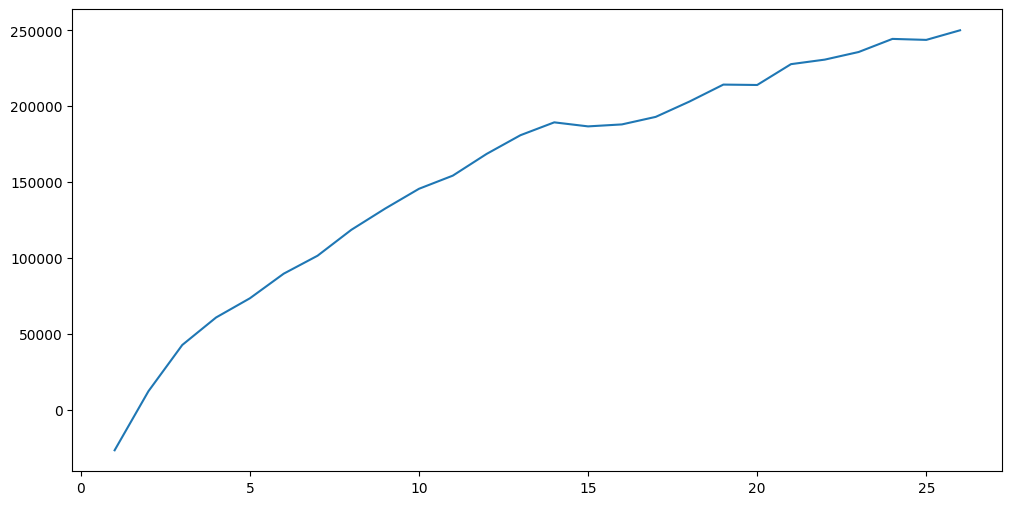

In [36]:
X = np.array(omdb_genre_learning_table)
Ks = range(1, 27)
genre_models = [KMeans(n_clusters = i, init="k-means++", random_state=0).fit(X) for i in Ks]
# now run for each cluster the BIC computation
BIC = [compute_bic(kmeansi,X) for kmeansi in genre_models]
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.plot(Ks,BIC)
plt.show()

In [37]:
final_genre_model = genre_models[9]
omdb_genre_learning_clusters = omdb_genre_learning_table.copy()
omdb_genre_learning_clusters['genre_cluster'] = final_genre_model.labels_
omdb_genre_learning_clusters_df = omdb_genre_learning_clusters.reset_index()

In [38]:
omdb_bom_combine_df = pd.DataFrame(omdb_bom_combine, columns=["key_bom", "key_omdb", "omdb_movie_id"])
omdb_bom_cluster_df = pd.merge(omdb_bom_combine_df, omdb_genre_learning_clusters_df,  how='inner', on=['omdb_movie_id'])

In [39]:
print(movie_df.shape)
movie_df1 = movie_df.merge(omdb_bom_cluster_df[["key_bom", "genre_cluster"]],how="left",on="key_bom")
print(movie_df1.shape)

(2373, 18)
(2373, 19)


In [40]:
movie_df2 = movie_df1.merge(bom[["key_bom","bom_genre"]],how="left",on="key_bom")
print(movie_df2.shape)

(2373, 20)


In [41]:
bom_genre_coding = [('Action', 5), ('Action / Adventure', 5), ('Action / Crime', 5),('Action Comedy',1),
                    ('Action Drama',5),('Action Fantasy',5),('Action Horror',7),('Action Thriller',5),('Adventure',5),
                    ('Adventure Comedy',1),('Animation',2),('Comedy',3),('Comedy / Drama',3),('Comedy Thriller',1),
                    ('Concert',4),('Crime',5),('Crime Comedy',1),('Crime Drama',0),('Crime Thriller',5),
                    ('Documentary',4),('Drama',0),('Drama / Thriller',0),('Family',2),('Family Adventure',2),
                    ('Family Comedy',3),('Fantasy',5),('Fantasy Comedy',1),('Fantasy Drama',0),('Historical Drama',0),
                    ('Historical Epic',0),('Horror',7),('Horror Comedy',1),('Horror Thriller',7),('Music Drama',0),
                    ('Musical',0),('Period Action',5),('Period Adventure',5),('Period Drama',0),('Period Horror',7),
                    ('Romance',9),('Romantic Comedy',6),('Romantic Thriller',9),('Sci-Fi',7),('Sci-Fi Action',5),
                    ('Sci-Fi Adventure',5),('Sci-Fi Comedy',1),('Sci-Fi Fantasy',5),('Sci-Fi Horror',7),
                    ('Sci-Fi Thriller',7),('Sports Comedy',1),('Sports Drama',0),('Thriller',7),('Unknown',4),
                    ('War',0),('War Drama',0),('Western',8),('Western Comedy',8),('Period Comedy',1),('Foreign',4),
                    ('Foreign / Action',5),('War Romance',9),('IMAX',4),('Romantic Adventure',9),
                    ('Foreign / Horror',7),('Sports Action',5)]
bom_genre_coding_dict = dict(bom_genre_coding)

In [42]:
import math
for index, row in movie_df2.iterrows():
    if math.isnan(row['genre_cluster']):
        movie_df2.at[index,'genre_cluster'] = bom_genre_coding_dict[row['bom_genre']]
movie_df2['genre_cluster'] = movie_df2['genre_cluster'] + 1

temp = movie_df2[["key_bom","genre_cluster","bom_genre"]]
# temp.to_csv("data/temp-data/temp.csv",index=None)

In [43]:
movie_df = movie_df2

## Features Related to Player Score

In [44]:
bom_f = bom[['key_bom','bom_actor','bom_director','bom_writer','bom_distributor','bom_composer','bom_cinematographer',
            "bom_producer"]]

In [45]:
movie_df = pd.merge(movie_df,bom_f,on="key_bom",how="left")
movie_df = movie_df.reset_index()
print(movie_df.shape)
movie_df.head(3)

(2373, 28)


,index,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre,bom_actor,bom_director,bom_writer,bom_distributor,bom_composer,bom_cinematographer,bom_producer
0,0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00,07,3.0,198,28,2009,1 hrs. 35 min.,95.0,,0.0,0.0,PG-13,3.0,10.0,Romance,"""['Zooey Deschanel', 'Geoffrey Arend', 'Chloe Moretz', 'Clark Gregg', 'Minka Kelly*']""",['Marc Webb'],"""['Scott Neustadter', 'Michael H. Weber']""\r",Fox Searchlight,"""['Mychael Danna', 'Rob Simonsen']""",,"""['Mason Novick', 'Mark S. Waters']"""
1,1,b24,10 things i hate about you,30000000.0,53478166.0,0.782606,1999-03-31 00:00:00,03,1.0,90,13,1999,1 hrs. 37 min.,97.0,,0.0,0.0,PG-13,3.0,7.0,Romantic Comedy,"""['Julia Stiles', 'Heath Ledger']""",,"""['Karen McCullah Lutz', 'Kirsten Smith']""\r",Buena Vista,,,"""['Jeffrey Chernov', 'Andrew Lazar']"""
2,2,b27,"""10,000 b.c.""",105000000.0,269784201.0,1.569373,2008-03-07 00:00:00,03,1.0,67,9,2008,1 hrs. 49 min.,109.0,,0.0,0.0,PG-13,3.0,6.0,Period Adventure,"""['Steven Strait', 'Camilla Belle']""",['Roland Emmerich'],"""['Roland Emmerich', 'Harald Kloser']""\r",Warner Bros.,"""['Harald Kloser', 'Thomas Wander']""",,"""['Mark Gordon', 'Harald Kloser', 'Scott Mednick', 'Thomas Tull']"""


In [46]:
def clean_people(movie_data, ind, peeps):
    """
    Function to clean people associated with movies
    """
    peeps_clean = peeps+'_clean'
    bom_ftr = movie_data[[ind, peeps]].copy()
    bom_ftr[peeps_clean] = bom_ftr[peeps].str.replace('[','')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace(']','')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace('"','')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace("'",'')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace("*",'')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace("|",',')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace(", ",',')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].replace(np.nan, '', regex=True)
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].apply(lambda x: x.split(','))
    print('Cleaned', peeps)
    clean_movie_data = pd.merge(movie_data, bom_ftr[[ind, peeps_clean]], on = "index")
    return clean_movie_data

In [47]:
movies_f = movie_df
movies_f = clean_people(movies_f, 'index', 'bom_actor')
movies_f = clean_people(movies_f, 'index', 'bom_director')
movies_f = clean_people(movies_f, 'index', 'bom_writer')
movies_f = clean_people(movies_f, 'index', 'bom_distributor')
movies_f = clean_people(movies_f, 'index', 'bom_composer')
movies_f = clean_people(movies_f, 'index', 'bom_cinematographer')
movies_f = clean_people(movies_f, 'index', 'bom_producer')

Cleaned bom_actor
Cleaned bom_director
Cleaned bom_writer
Cleaned bom_distributor
Cleaned bom_composer
Cleaned bom_cinematographer
Cleaned bom_producer


In [48]:
print(movies_f.shape)
#Removing redinant columns
movies_f = movies_f.drop('bom_actor',axis = 1)
movies_f = movies_f.drop('bom_director',axis = 1)
movies_f = movies_f.drop('bom_writer',axis = 1)
movies_f = movies_f.drop('bom_distributor',axis = 1)
movies_f = movies_f.drop('bom_composer',axis = 1)
movies_f = movies_f.drop('bom_cinematographer',axis = 1)
movies_f = movies_f.drop('bom_producer',axis = 1)
print(movies_f.shape)
print(movies_f.columns)

(2373, 35)
(2373, 28)
Index(['index', 'key_bom', 'bom_title', 'bom_budget', 'bom_worldwide_revenue', 'revenue', 'bom_release_date', 'release_month', 'release_quarter', 'release_day_of_the_year', 'release_week_of_the_year', 'release_year', 'bom_runtime', 'runtime', 'bom_awards', 'bom_awards_scr', 'holiday_season', 'bom_rating', 'mpaa_rating', 'genre_cluster', 'bom_genre', 'bom_actor_clean', 'bom_director_clean', 'bom_writer_clean', 'bom_distributor_clean', 'bom_composer_clean', 'bom_cinematographer_clean', 'bom_producer_clean'], dtype='object')


In [49]:
def people_score(movie_data, peeps, rev, awa):
    """
    Getting unique actors
    """
    start_time = time.time()
    peep_unq = list(movie_data[peeps])
    peep_unq = list(set(sum(peep_unq, [])))
    peep_unq = [e for e in peep_unq if e not in ('', ' ')]
    peep_cnt = dict((ky,0) for ky in peep_unq)
    peep_awa = dict((ky,0) for ky in peep_unq)
    peep_acn = dict((ky,0) for ky in peep_unq)
    peep_unq = dict((ky,0) for ky in peep_unq)
    print('Unique', peeps, ': ', len(peep_unq))

    # For each actor, assigning score based on revenue of their movie
    mov_peeps = list(movie_data[peeps])
    mov_peeps = [[actor for actor in mov if actor not in ('', ' ')] for mov in mov_peeps]
    ind = 0
    for actors in mov_peeps:
        for actor in actors:
            peep_unq[actor] += float(movie_data.loc[ind, [rev]])
            peep_cnt[actor] += 1
            peep_awa[actor] += int(movie_data.loc[ind, [awa]])
            if int(movie_data.loc[ind, [awa]]) != 0: peep_acn[actor] += 1
        ind+=1
    print("Time taken: " + str(round(time.time() - start_time,2)) + " seconds\n")
    return (peep_unq, peep_cnt, peep_awa, peep_acn)

In [50]:
import warnings
warnings.filterwarnings('ignore')

# Normalizing revenue and bom award score
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
movies_f['revenue_norm'] = min_max_scaler.fit_transform(movies_f[['revenue']])
movies_f['bom_awards_scr_norm'] = min_max_scaler.fit_transform(movies_f[['bom_awards_scr']])

In [51]:
# Storing people scores
unq_dir, cnt_dir, awa_dir, acn_dir = people_score(movies_f, 'bom_director_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_act, cnt_act, awa_act, acn_act = people_score(movies_f, 'bom_actor_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_wri, cnt_wri, awa_wri, acn_wri = people_score(movies_f, 'bom_writer_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_dis, cnt_dis, awa_dis, acn_dis = people_score(movies_f, 'bom_distributor_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_com, cnt_com, awa_com, acn_com = people_score(movies_f, 'bom_composer_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_cin, cnt_cin, awa_cin, acn_cin = people_score(movies_f, 'bom_cinematographer_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_pro, cnt_pro, awa_pro, acn_pro = people_score(movies_f, 'bom_producer_clean', 'revenue_norm', 'bom_awards_scr_norm')

Unique bom_director_clean :  730
Time taken: 2.67 seconds

Unique bom_actor_clean :  1975
Time taken: 17.89 seconds

Unique bom_writer_clean :  1083
Time taken: 5.28 seconds

Unique bom_distributor_clean :  115
Time taken: 3.71 seconds

Unique bom_composer_clean :  145
Time taken: 2.68 seconds

Unique bom_cinematographer_clean :  77
Time taken: 0.92 seconds

Unique bom_producer_clean :  767
Time taken: 8.29 seconds



In [52]:
def mean_awards(awa, acn):
    """
    Getting mean of awards
    """
    awa_mea = {}
    for k in awa.keys():
        if awa[k] != 0:
            awa_mea[k] = awa[k]/acn[k]
        else:
            awa_mea[k] = awa[k]
    return awa_mea

In [53]:
# Storing mean of awards in variable
awa_mea_act = mean_awards(awa_act, acn_act)
awa_mea_dir = mean_awards(awa_dir, acn_dir)
awa_mea_wri = mean_awards(awa_wri, acn_wri)
awa_mea_dis = mean_awards(awa_dis, acn_dis)
awa_mea_com = mean_awards(awa_com, acn_com)
awa_mea_cin = mean_awards(awa_cin, acn_cin)
awa_mea_pro = mean_awards(awa_pro, acn_pro)

In [54]:
# Calculating the mean of the score for the people
w = 1
mean_act = {k: (unq_act[k]/cnt_act[k])+ (w*(awa_mea_act[k])) for k in unq_act.keys()}
mean_dir = {k: (unq_dir[k]/cnt_dir[k])+(w*(awa_mea_dir[k])) for k in unq_dir.keys()}
mean_wri = {k: (unq_wri[k]/cnt_wri[k])+(w*(awa_mea_wri[k])) for k in unq_wri.keys()}
mean_dis = {k: (unq_dis[k]/cnt_dis[k])+(w*(awa_mea_dis[k])) for k in unq_dis.keys()}
mean_com = {k: (unq_com[k]/cnt_com[k])+(w*(awa_mea_com[k])) for k in unq_com.keys()}
mean_cin = {k: (unq_cin[k]/cnt_cin[k])+(w*(awa_mea_cin[k])) for k in unq_cin.keys()}
mean_pro = {k: (unq_pro[k]/cnt_pro[k])+(w*(awa_mea_pro[k])) for k in unq_pro.keys()}

In [55]:
actor='Meryl Streep'
dirtr = 'Christopher Nolan'
print(unq_act[actor], cnt_act[actor], awa_act[actor], acn_act[actor], awa_mea_act[actor], mean_act[actor])
print(unq_dir[dirtr], cnt_dir[dirtr], awa_dir[dirtr], acn_dir[dirtr], awa_mea_dir[dirtr], mean_dir[dirtr])

5.1009905888914036 19 0 0 0 0.2684731888890212
2.833793850537397 8 0 0 0 0.3542242313171746


In [56]:
def movie_people_score(movie_data, peeps, peeps_score):
    """
    For each movie, assigning player score
    """
    mov_peeps = list(movie_data[peeps])
    mov_peeps = [[actor for actor in mov if actor not in ('', ' ')] for mov in mov_peeps]
    ind = 0
    mov_score = []
    for actors in mov_peeps:
        agg_actor_score = 0
        for actor in actors:
            agg_actor_score += peeps_score[actor]
        mov_score.append(agg_actor_score)
        ind+=1
    return mov_score

In [57]:
# Creating new columns for player scores
movies_f["actor_score"] = movie_people_score(movies_f, 'bom_actor_clean', mean_act)
movies_f["director_score"] = movie_people_score(movies_f, 'bom_director_clean', mean_dir)
movies_f["writer_score"] = movie_people_score(movies_f, 'bom_writer_clean', mean_wri)
movies_f["distributor_score"] = movie_people_score(movies_f, 'bom_distributor_clean', mean_dis)
movies_f["composer_score"] = movie_people_score(movies_f, 'bom_composer_clean', mean_com)
movies_f["cinematographer_score"] = movie_people_score(movies_f, 'bom_cinematographer_clean', mean_cin)
movies_f["producer_score"] = movie_people_score(movies_f, 'bom_producer_clean', mean_pro)

In [58]:
movie_df = movies_f
print(movie_df.shape)
movie_df.head(1)

(2373, 37)


,index,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre,bom_actor_clean,bom_director_clean,bom_writer_clean,bom_distributor_clean,bom_composer_clean,bom_cinematographer_clean,bom_producer_clean,revenue_norm,bom_awards_scr_norm,actor_score,director_score,writer_score,distributor_score,composer_score,cinematographer_score,producer_score
0,0,b10,(500) days of summer,7500000.0,60722734.0,7.096365,2009-07-17 00:00:00,07,3.0,198,28,2009,1 hrs. 35 min.,95.0,,0.0,0.0,PG-13,3.0,10.0,Romance,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly]",[Marc Webb],"[Scott Neustadter, Michael H. Weber\r]",[Fox Searchlight],"[Mychael Danna, Rob Simonsen]",[],"[Mason Novick, Mark S. Waters]",0.736845,0.0,2.011784,0.518337,0.989326,0.314074,0.618026,0.0,1.063533


In [59]:
# Entering scores into database
def insert_scores_db(tab, peeps_scores):
    peeps_scores['Unknown'] = min(peeps_scores.values())
    
    vals = ''
    for key, value in peeps_scores.items(): vals += "('" + key + "'," + str(value) + '), '
    vals = vals[:-2]
    
    with open('../mysql_cred') as f:
        credentials = [x.strip().split(':') for x in f.readlines()]
    connection = pymysql.connect(host=credentials[0][0], user=credentials[0][1], password=credentials[0][2], db='movies')
    
    cur = connection.cursor()
    cur.execute("drop table if exists %s;" %(tab))
    cur.execute("create table %s(name varchar(100), score float);" %(tab))
    cur.execute("INSERT INTO %s (name, score) VALUES %s;" %(tab, vals))
    cur.execute('commit;')
    print('Inserted', len(peeps_scores), 'values into table:', tab)
    cur.close()
    connection.close()

In [60]:
# insert_scores_db('scores_act', mean_act)
# insert_scores_db('scores_dir', mean_dir)
# insert_scores_db('scores_wri', mean_wri)
# insert_scores_db('scores_dis', mean_dis)
# insert_scores_db('scores_com', mean_com)
# insert_scores_db('scores_cin', mean_cin)
# insert_scores_db('scores_pro', mean_pro)

## Features Based on Genre Based Best People

In [61]:
def getGenreBasedPeeps(genre,peeps,n,mean_dict):
    genre_cluster_movie = movies_f.loc[movies_f['genre_cluster']==genre]
    peep_unq = list(genre_cluster_movie[peeps])
    peep_unq = list(set(sum(peep_unq, [])))
    peep_unq = [e for e in peep_unq if e not in ('', ' ')]
    
    score_list = [mean_dict[x] for x in peep_unq]
    sorted_idx = [i[0] for i in sorted(enumerate(score_list), key=lambda x:x[1], reverse=True)]
    return list(np.array(peep_unq)[sorted_idx][:n])

In [62]:
# Entering scores into database
def insert_genre_peeps_db(tab, peeps_scores):
    vals = ''
    for item in peeps_scores:
        vals += "('" + item[0] + "'," + str(item[1]) + "," + str(item[2]) + ",'" + item[3] + "'), "
    vals = vals[:-2]
    
    with open('../mysql_cred') as f:
        credentials = [x.strip().split(':') for x in f.readlines()]
    connection = pymysql.connect(host=credentials[0][0], user=credentials[0][1], password=credentials[0][2], db='movies')
    
    cur = connection.cursor()
    cur.execute("drop table if exists %s;" %(tab))
    cur.execute("create table %s(name varchar(100), score float, cluster int, genre varchar(100));" %(tab))
    cur.execute("INSERT INTO %s (name, score, cluster, genre) VALUES %s;" %(tab, vals))
    cur.execute('commit;')
    print('Inserted', len(peeps_scores), 'values into table:', tab)
    cur.close()
    connection.close()

In [63]:
genre_desc = ['Drama','Parody','Animation','Comedy','Documentary','Action','Romantic Comedy',
              'Thriller','Western','Romantic']
act_genre_data = []
dir_genre_data = []
wri_genre_data = []

for i in range(1,11):
    act_genre = getGenreBasedPeeps(i,'bom_actor_clean',10,mean_act)
    dir_genre = getGenreBasedPeeps(i,'bom_director_clean',10,mean_dir)
    wri_genre = getGenreBasedPeeps(i,'bom_writer_clean',10,mean_wri)
    for actor in act_genre:
        act_genre_data.append((actor.strip(),mean_act[actor],i,genre_desc[i-1]))
    for director in dir_genre:
        dir_genre_data.append((director.strip(),mean_dir[director],i,genre_desc[i-1]))
    for writer in wri_genre:
        wri_genre_data.append((writer.strip(),mean_wri[writer],i,genre_desc[i-1]))

        
# insert_genre_peeps_db('best_genre_actors',act_genre_data)
# insert_genre_peeps_db('best_genre_directors',dir_genre_data)
# insert_genre_peeps_db('best_genre_writers',wri_genre_data)

In [64]:
#movie_df.to_csv("data/bom_final.csv",index=None)

## Segregate Data

In [65]:
X_budget = np.array(movie_df['bom_budget'])
Ks = range(1, 10)
kmeans_budget = [KMeans(n_clusters=i, random_state=0) for i in Ks]
score_budget = [kmeans_budget[i].fit(X_budget.reshape(-1,1)).score(X_budget.reshape(-1,1)) for i in range(len(kmeans_budget))]

In [66]:
score_budget[:2]

[-5.220134910564309e+18, -1.6732074932553828e+18]

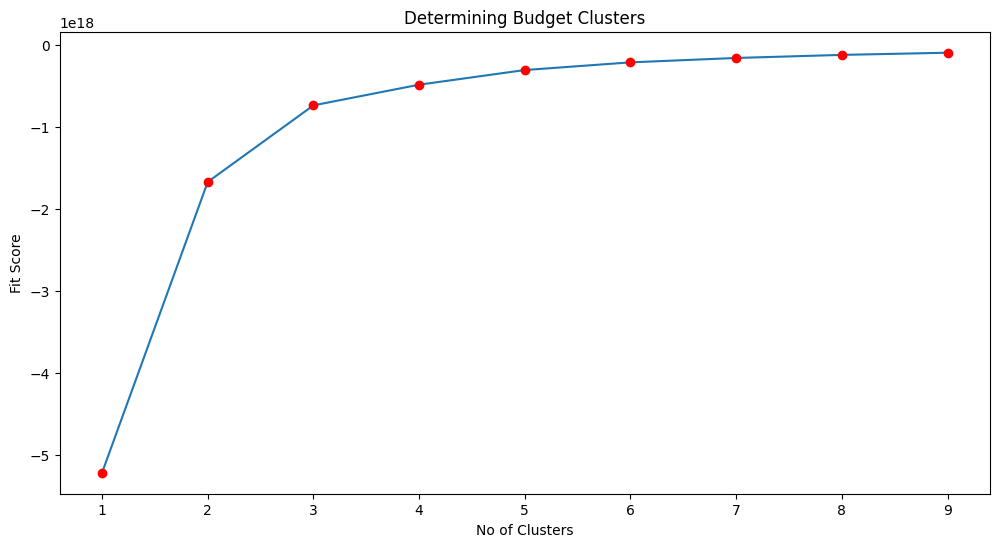

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(Ks,score_budget)
plt.xlabel('No of Clusters')
plt.ylabel('Fit Score')
plt.title('Determining Budget Clusters')
plt.plot(Ks, score_budget, 'ro')
plt.show()

In [68]:
kmeans_budget[3].fit(X_budget.reshape(-1,1)).labels_

array([1, 1, 0, ..., 1, 1, 2], dtype=int32)

In [69]:
movie_df_1 = movie_df
movie_df_1['budget_cluster'] = kmeans_budget[2].labels_
movie_df_2 = movie_df_1.reset_index()

In [70]:
low_budget_df = movie_df_2.loc[movie_df_2['budget_cluster'] == 0]
mid_budget_df = movie_df_2.loc[movie_df_2['budget_cluster'] == 1]
high_budget_df = movie_df_2.loc[movie_df_2['budget_cluster'] == 2]

## Data Build-up for Modeling

In [71]:
#Normalizing the features
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

def standardize_features(t):
    cols = ['bom_budget',"bom_awards_scr","actor_score","director_score","writer_score",
                           "distributor_score", "composer_score", "cinematographer_score", "producer_score"]
    # Normalizing the features
    for c in cols:
        t[c]=standardize(t[c])
    return t

In [72]:
def lable_encode(t):
    cat = t[["release_month","release_week_of_the_year","release_quarter","release_day_of_the_year",
        "mpaa_rating","holiday_season","genre_cluster"]]
    
    le=LabelEncoder()
    # Iterating over all the common columns in train and test
    for col in cat.columns.values:
        # Encoding only categorical variables
        if t[col].dtypes=="object":
        # Using whole data to form an exhaustive list of levels
            data=t[col]
            le.fit(data.values)
            t[col]=le.transform(t[col])
    return t

In [73]:
def clean_up_low_budget(t):
    t = t.fillna("")
    t.loc[t.release_quarter == "",'release_quarter']= t.loc[t.release_quarter=="",'release_quarter'].apply(
        lambda x: float(x.replace('', '0')))
    t.loc[t.mpaa_rating == "",'mpaa_rating']= t.loc[t.mpaa_rating=="",'mpaa_rating'].apply(lambda x: float(
            x.replace('', '7')))
    t.loc[t.holiday_season == "",'holiday_season']= t.loc[t.holiday_season=="",'holiday_season'].apply(
        lambda x: float(x.replace('', '0')))
    return t

In [74]:
def data_build_up(t):
    t = t.reset_index(drop=True)
    t['bom_budget'] = t['bom_budget'].astype(float)
    t['bom_worldwide_revenue'] = t['bom_worldwide_revenue'].astype(float)
    t['revenue'] = t['revenue'].astype(float)
    if(t['budget_cluster'].all() == 0):
        t = clean_up_low_budget(t)
    t = lable_encode(t)
    t = standardize_features(t)
    return t

In [75]:
low_budget_df = data_build_up(low_budget_df)
mid_budget_df = data_build_up(mid_budget_df)
high_budget_df = data_build_up(high_budget_df)

In [76]:
low_budget_df.dtypes

level_0                        int64
index                          int64
key_bom                       object
bom_title                     object
bom_budget                   float64
bom_worldwide_revenue        float64
revenue                      float64
bom_release_date              object
release_month                  int64
release_quarter                int64
release_day_of_the_year        int64
release_week_of_the_year       int64
release_year                  object
bom_runtime                   object
runtime                      float64
bom_awards                    object
bom_awards_scr               float64
holiday_season                 int64
bom_rating                    object
mpaa_rating                    int64
genre_cluster                float64
bom_genre                     object
bom_actor_clean               object
bom_director_clean            object
bom_writer_clean              object
bom_distributor_clean         object
bom_composer_clean            object
b

## Serializing Data

In [77]:
pickle.dump(final_genre_model, open('model/genre.mprophet','wb'), protocol=0)
pickle.dump(omdb_genre_learning_table[0:0], open('data/genre_df.mprophetdata','wb'), protocol=0)

In [78]:
pickle.dump(low_budget_df, open('data/low_budget.mprophetdata','wb'), protocol=0)

In [79]:
pickle.dump(mid_budget_df, open('data/mid_budget.mprophetdata','wb'), protocol=0)

In [80]:
pickle.dump(high_budget_df, open('data/high_budget.mprophetdata','wb'), protocol=0)